**Transfer Learning**
https://www.learnopencv.com/image-classification-using-transfer-learning-in-pytorch/

In [1]:
import torch, torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchsummary import summary # pip install torchsummary

import numpy as np
import matplotlib.pyplot as plt
import os
import time
from PIL import Image

In [2]:
# device 
print(torch.cuda.device(0))
print(torch.cuda.get_device_name(0))
print(torch.cuda.device("cuda:0"))
print(torch.cuda.get_device_name("cuda:0"))

GeForce GTX 1660 Ti
GeForce GTX 1660 Ti


In [3]:
# check directory
root_dir = "datasets/example_vid_small/train/people"
len(os.listdir(root_dir))

864

In [4]:
# memory
t = torch.cuda.get_device_properties(0).total_memory
r = torch.cuda.memory_reserved(0) 
a = torch.cuda.memory_allocated(0)
f = r-a  # free inside reserved
print(t, r, a, f)

6442450944 0 0 0


In [5]:
# apply transformations

# augmentations for only training data | normalization for all
image_transforms = { 
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

In [6]:
# Load the Data

# directory paths for training and validation datasets
dataset = 'datasets/example_vid_small'

train_directory = os.path.join(dataset, 'train')
valid_directory = os.path.join(dataset, 'valid')

# batch size
bs = 32

# number of classes
num_classes = len(os.listdir(valid_directory))  #10#2#257
print(num_classes, "classes:")

# load data from folders
data = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),
    'valid': datasets.ImageFolder(root=valid_directory, transform=image_transforms['valid'])
}

# get a mapping of the indices to the class names to see the output classes of the test images
idx_to_class = {v: k for k, v in data['train'].class_to_idx.items()}
print(idx_to_class)

# size of data - to be used for calculating average loss and accuracy
train_data_size = len(data['train'])
valid_data_size = len(data['valid'])

# create iterators for the data loaded using dataLoader module
train_data_loader = DataLoader(data['train'], batch_size=bs, shuffle=True)
valid_data_loader = DataLoader(data['valid'], batch_size=bs, shuffle=True)

2 classes:
{0: 'no people', 1: 'people'}


In [7]:
# dataset sizes
total = train_data_size + valid_data_size

train_nop = len(os.listdir(f"{dataset}/train/{idx_to_class[0]}"))
train_ppl = len(os.listdir(f"{dataset}/train/{idx_to_class[1]}"))
valid_nop = len(os.listdir(f"{dataset}/valid/{idx_to_class[0]}"))
valid_ppl = len(os.listdir(f"{dataset}/valid/{idx_to_class[1]}"))

print(f"[{train_data_size}]----training images----| {train_nop} '{idx_to_class[0]}' {train_ppl} '{idx_to_class[1]}'")
print(f"[{valid_data_size}]----validation images---| {valid_nop} '{idx_to_class[0]}' {valid_ppl} '{idx_to_class[1]}'")
print(f"{round((train_data_size / total)*100, 2)}% train")
print(f"{round((valid_data_size / total)*100, 2)}% valid")

[1435]----training images----| 571 'no people' 864 'people'
[618]----validation images---| 219 'no people' 399 'people'
69.9% train
30.1% valid


In [8]:
alexnet = models.alexnet(pretrained=True)
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

- alexnet ouputs 1000 different classes: *(6): Linear(in_features=4096, out_features=1000, bias=True)*
- we will swap out this last layer with one tailored to our dataset (we only want 2 different outputs)

In [9]:
# freeze model parameters
for param in alexnet.parameters():
    param.requires_grad = False # gradient not computed during backpropagation

In [10]:
# change final layer
alexnet.classifier[6] = nn.Linear(4096, num_classes) 
# adding final softmax (normalizes output)
alexnet.classifier.add_module("7", nn.LogSoftmax(dim = 1))
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [11]:
alexnet = alexnet.to('cuda:0')
summary(alexnet, (3, 224, 224)) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

- due to freezing the layers, only 8194/~60 million parameters are trainable
- our last layer now only outputs 2 different classes

**Training**

In [12]:
# define optimizer and loss function
loss_func = nn.NLLLoss()
optimizer = optim.Adam(alexnet.parameters())
optimizer # using default optimizer parameters

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)

In [13]:
def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # set model to training mode
        model.train()
        
        # loss and accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(train_data_loader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # clean existing gradients
            optimizer.zero_grad()
            
            # forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # compute loss
            loss = loss_criterion(outputs, labels)
            
            # backpropagate the gradients
            loss.backward()
            
            # update the parameters
            optimizer.step()
            
            # compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

            
        # validation - no gradient tracking needed
        with torch.no_grad():

            # set model to evaluation mode
            model.eval()

            # validation loop
            for j, (inputs, labels) in enumerate(valid_data_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # compute loss
                loss = loss_criterion(outputs, labels)

                # compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
        # find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size

        # find average training loss and training accuracy
        avg_valid_loss = valid_loss/valid_data_size 
        avg_valid_acc = valid_acc/valid_data_size

        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])
                
        epoch_end = time.time()
    
        print("[Training]   Loss: {:.4f} | Accuracy: {:.4f}%\n[Validation] Loss: {:.4f} | Accuracy: {:.4f}% \nTime: {:.4f}s".format(avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))
        print("{============================================}")
        # Save if the model has best accuracy till now
        #torch.save(model, dataset+'_model_'+str(epoch)+'.pt')
            
    return model, history

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

num_epochs = 8
trained_model, history = train_and_validate(alexnet, loss_func, optimizer, num_epochs)

# NEED TO FIX
#path = os.listdir()
#torch.save(history, dataset+'_history.pt', path)
#torch.save(trained_model.state_dict(), path)

Epoch: 1/8
[Training]   Loss: 0.2752 | Accuracy: 88.9199%
[Validation] Loss: 0.0848 | Accuracy: 97.5728% 
Time: 43.7735s
{============================================}
Epoch: 2/8
[Training]   Loss: 0.1903 | Accuracy: 93.6585%
[Validation] Loss: 0.0834 | Accuracy: 96.2783% 
Time: 39.0087s
{============================================}
Epoch: 3/8
[Training]   Loss: 0.1693 | Accuracy: 94.0767%
[Validation] Loss: 0.1173 | Accuracy: 92.2330% 
Time: 39.8554s
{============================================}
Epoch: 4/8
[Training]   Loss: 0.1569 | Accuracy: 94.7735%
[Validation] Loss: 0.0964 | Accuracy: 94.6602% 
Time: 38.9459s
{============================================}
Epoch: 5/8
[Training]   Loss: 0.1648 | Accuracy: 93.3101%
[Validation] Loss: 0.2224 | Accuracy: 87.3786% 
Time: 39.5403s
{============================================}
Epoch: 6/8
[Training]   Loss: 0.1438 | Accuracy: 94.0767%
[Validation] Loss: 0.1505 | Accuracy: 90.6149% 
Time: 39.3807s
{======================================

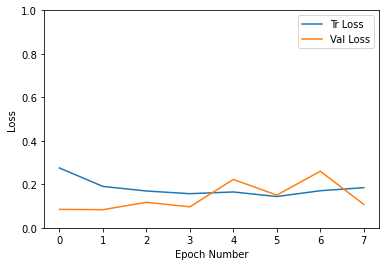

In [15]:
history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,1)
plt.savefig(dataset+'_loss_curve.png')
plt.show()

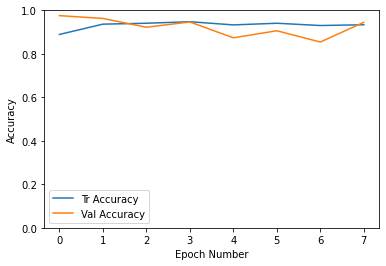

In [16]:
plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.savefig(dataset+'_accuracy_curve.png')
plt.show()

In [17]:
def predict(model, test_image_name):
    '''
    Function to predict the class of a single test image
    Parameters
        :param model: Model to test
        :param test_image_name: Test image

    '''
    
    transform = image_transforms['test']

    test_image = Image.open(test_image_name)
    plt.imshow(test_image)
    plt.axis('off')
    
    test_image_tensor = transform(test_image)

    if torch.cuda.is_available():
        test_image_tensor = test_image_tensor.view(1, 3, 224, 224).cuda()
    else:
        test_image_tensor = test_image_tensor.view(1, 3, 224, 224)
    
    with torch.no_grad():
        model.eval()
        # model outputs log probabilities
        out = model(test_image_tensor).cpu()
        ps = torch.exp(out)
        topk, topclass = ps.topk(2, dim=1)
        for i in range(2): # 0, 1
            print("Predcition", i+1, ":", idx_to_class[topclass.numpy()[0][i]], ", Score: ", topk.numpy()[0][i])

In [18]:
lst = []
test_dir = "datasets/example_vid_small/test/"
arr = os.listdir(test_dir)
for i in arr:
    lst.append(i)
lst 

['Boriana - ch04_20170525134117_720_2 0307.jpg',
 'Boriana - ch04_20170525134117_720_2 0488.jpg',
 'Boriana - ch04_20170525134117_720_2 0664.jpg',
 'Boriana - ch04_20170525134117_720_2 0781.jpg',
 'Boriana - ch04_20170525134117_720_2 1252.jpg',
 'Boriana - ch04_20170525134117_720_2 1253.jpg',
 'Boriana - ch04_20170525134117_720_2 1254.jpg',
 'Boriana - ch04_20170525134117_720_2 1437.jpg',
 'Boriana - ch04_20170525134117_720_2 1752.jpg',
 'Boriana - ch04_20170525134117_720_2 2139.jpg',
 'Boriana - ch04_20170525134117_720_2 2460.jpg',
 'Boriana - ch04_20170525134117_720_2 2684.jpg']

Predcition 1 : people , Score:  0.99963796
Predcition 2 : no people , Score:  0.0003620211


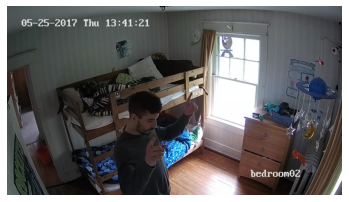

In [19]:
predict(trained_model, f"{test_dir}{lst[0]}")

Predcition 1 : no people , Score:  0.58120376
Predcition 2 : people , Score:  0.41879618


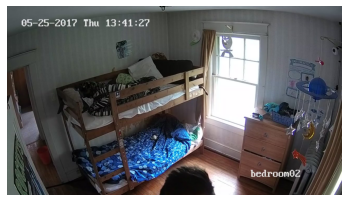

In [20]:
predict(trained_model, f"{test_dir}{lst[1]}")

Predcition 1 : people , Score:  0.8879322
Predcition 2 : no people , Score:  0.11206784


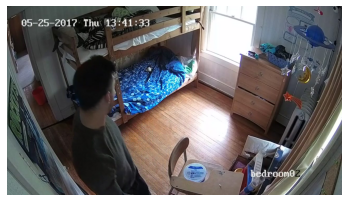

In [21]:
predict(trained_model, f"{test_dir}{lst[2]}")

Predcition 1 : no people , Score:  0.7107054
Predcition 2 : people , Score:  0.28929457


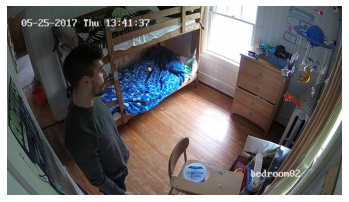

In [22]:
predict(trained_model, f"{test_dir}{lst[3]}")

Predcition 1 : no people , Score:  0.99997246
Predcition 2 : people , Score:  2.7571425e-05


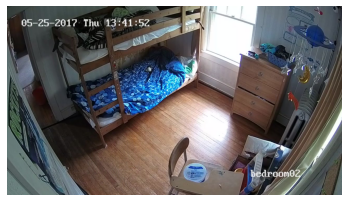

In [23]:
predict(trained_model, f"{test_dir}{lst[4]}")

Predcition 1 : no people , Score:  0.99997115
Predcition 2 : people , Score:  2.8858336e-05


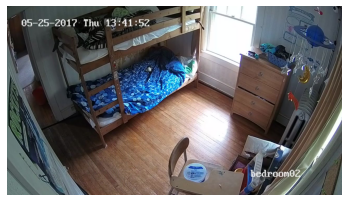

In [24]:
predict(trained_model, f"{test_dir}{lst[5]}")

Predcition 1 : no people , Score:  0.99997115
Predcition 2 : people , Score:  2.8815435e-05


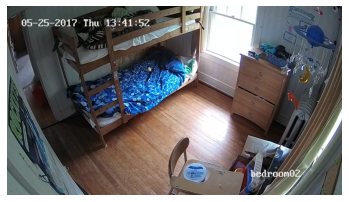

In [25]:
predict(trained_model, f"{test_dir}{lst[6]}")

Predcition 1 : people , Score:  0.9995437
Predcition 2 : no people , Score:  0.00045623566


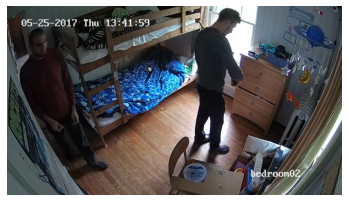

In [26]:
predict(trained_model, f"{test_dir}{lst[7]}")

Predcition 1 : people , Score:  0.98635405
Predcition 2 : no people , Score:  0.013645931


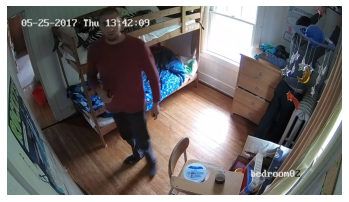

In [27]:
predict(trained_model, f"{test_dir}{lst[8]}")

Predcition 1 : people , Score:  0.9995395
Predcition 2 : no people , Score:  0.00046054026


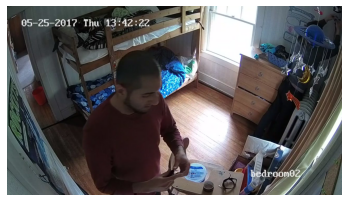

In [28]:
predict(trained_model, f"{test_dir}{lst[9]}")

Predcition 1 : people , Score:  1.0
Predcition 2 : no people , Score:  2.9379057e-09


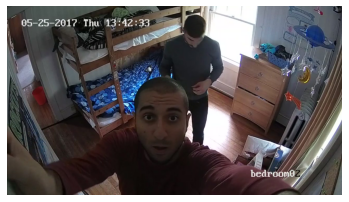

In [29]:
predict(trained_model, f"{test_dir}{lst[10]}")

Predcition 1 : people , Score:  1.0
Predcition 2 : no people , Score:  1.2613561e-11


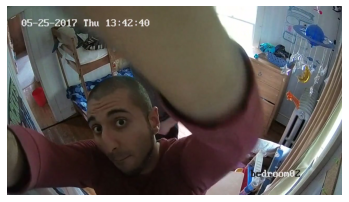

In [30]:
predict(trained_model, f"{test_dir}{lst[11]}")